#### ML_INFN Hackathon - Entry level
# The basics of the Classification task, a classical application to High Energy Physics
**Contact**: Lucio.Anderlini [at] fi.infn.it


In the previous lectures we introduced the concept of Deep Neural Network and we introduced the tasks of regression and classification.
We have also introduced Jupyter, numpy, pandas and keras as a framework for numerical data analysis.

In this notebook we will see a first application of a very simple neural network to perform classification.
We will frame our problem in the context of High Energy Physics, but the concepts and the methods we discuss are more general.

#### Problem statement
Given a dataset of simulated collisions as obtained assuming the Standard Model and theoretical contributions beyond the Standard Model, we aim at enhancing our ability of idenifying such contributions in acquired data by combining the discrimination power of multiple variables.

**Disclaimer.** The purpose of this exercise is to provide a wide overview of the logical procedure for applying multivariate classifiers in High Energy Physics. It is not meant to provide a complete guide for applying machine learning to real-world analyses.

#### Dataset
We will discuss the classification problem on a reduced version of the [HEPMASS dataset](http://archive.ics.uci.edu/dataset/347/hepmass), made [available](https://pandora.infn.it/public/cba2c5/dl/reduced_hepmass_fixed.feather) on INFN pandora.

The dataset is stored in *feather* format and features the following columns:
 * `label`: 0 for the Standard Model events, 1 for the BSM contributions;
 * `mass`: the mass of a hypothetical new particle beyond the Standard Model, or NaN for a Standard Model event
 * `pt1` and `pt2`: proxies for low-level quantities (in this case representing the transverse momentum of reconstructed particles)
 * `m1` and `m2`: proxies for high-level quantities (in this case representing invariant masses of particle pairs)


In this exercise, we will restrain the problem to a single mass hypothesis,while exploring the techniques to handle the theoretical uncertainty on the mass of the hypothetical particle is left to the reader.



## Getting started

 * Importing the libraries
 * Downloading the dataset
 * Selecting the dataset relevant to the exercise (defining the mass hypothesis)

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

!pip install -q pyarrow

df = (pd
      .read_feather("https://pandora.infn.it/public/cba2c5/dl/reduced_hepmass_fixed.feather")
      .query("label == 0 or mass == 1000")
)
df


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


,label,mass,pt1,pt2,m1,m2
0,1,1000.0,1.989833,2.269852,1.130032,2.227706
2,0,NaN,-1.150495,-1.031239,-0.523262,-1.506304
4,0,NaN,-0.595304,-0.181512,-0.150760,-1.023889
6,0,NaN,0.847562,-0.786011,1.492983,0.035637
7,0,NaN,-0.033880,0.505265,-0.081876,0.011046
...,...,...,...,...,...,...
6999988,0,NaN,-1.388837,-0.920994,-0.848979,-1.425044
6999991,0,NaN,-0.632075,-0.275358,-0.460288,-0.979613
6999994,1,1000.0,-1.223569,-1.037000,-0.120612,-0.911606
6999995,0,NaN,0.596391,0.642273,1.340297,0.267774


### Splitting the dataset into **Signal** and **Background**

We are trying to enhance the new physics contributions making them stand over the known, Standard Model part.
Hence, we will call *Background* the Standard Model contribution that we are trying to reject and *Signal* the contributions we are trying to enhance.


In [2]:
sig = df.query("label == 1")
bkg = df.query(f"label == 0")

print (f"Selected {len(sig)} signal events and {len(bkg)} background events")

Selected 701440 signal events and 3499121 background events


## Explorative analysis and feature selection

We begin plotting the distributions with respect to the four variables for the signal and background, separately.

This exploratory step is often useful to discard features providing no discrimination power between signal and background.

Sometimes, it is also used to identify the "most" discriminant variable which is used in the last part of the analysis to "visualize" the signal and background contributions, possibly performing a counting experiment.
We will use the feature `m2` to the purpose.

In this dataset, the features are already preprocessed, scaling them to be roughly centered in zero and with a standard deviation of the order of 1.

In general, preprocessing should be applied at this stage in the analysis.

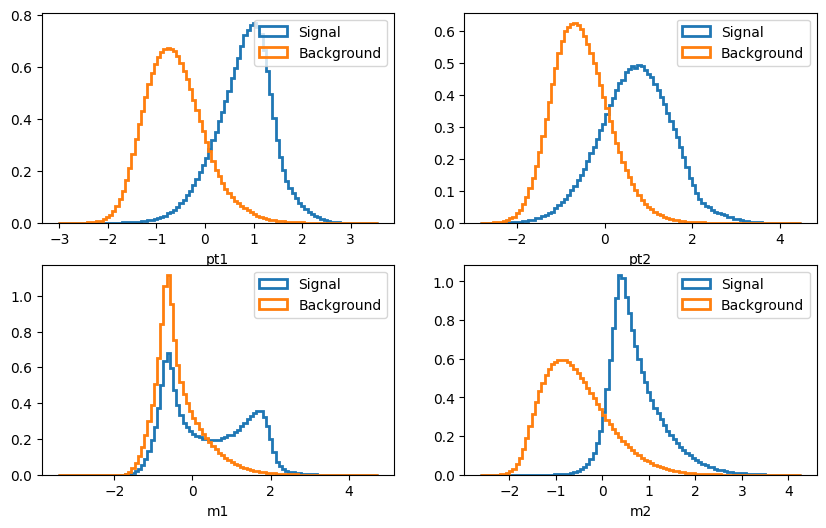

In [3]:
plt.figure(figsize=(10,6))
all_vars = ['pt1', 'pt2', 'm1', 'm2']
for iPlot, var in enumerate(all_vars, 1):
    plt.subplot(2, 2, iPlot)
    _, bins = np.histogram(df[var], bins=100)
    plt.hist(sig[var], bins, label="Signal", histtype='step', linewidth=2, density=True)
    plt.hist(bkg[var], bins, label="Background", histtype='step', linewidth=2, density=True)
    plt.xlabel(var)
    plt.legend()
plt.show()

# A very simple classifier

Let's define a minimal classifier.

To speed-up the training, we pick only a subset of the dataset, for example the first 10'000 events.

We define the model, the loss function, the optimizer and then we perform the training.

In [4]:
dfh = df.head(10_000)

vars = ['pt1', 'pt2', 'm1']

classifier = tf.keras.models.Sequential()
classifier.add (tf.keras.layers.Dense(128, activation='tanh'))
classifier.add (tf.keras.layers.Dense(1, activation='sigmoid'))

classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-3))

history = classifier.fit(dfh[vars].values, dfh['label'], batch_size=1024, epochs=10)

Epoch 1/10


2023-06-14 15:40:22.851381: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-14 15:40:22.869346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-14 15:40:22.870473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-14 15:40:22.871906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

10/10 [==============================] - 1s 2ms/step - loss: 0.7251
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5445
Epoch 3/10
10/10 [==============================] - 0s 2ms/step - loss: 0.4254
Epoch 4/10
10/10 [==============================] - 0s 2ms/step - loss: 0.3519
Epoch 5/10
10/10 [==============================] - 0s 2ms/step - loss: 0.3069
Epoch 6/10
10/10 [==============================] - 0s 2ms/step - loss: 0.2791
Epoch 7/10
10/10 [==============================] - 0s 2ms/step - loss: 0.2609
Epoch 8/10
10/10 [==============================] - 0s 2ms/step - loss: 0.2485
Epoch 9/10
10/10 [==============================] - 0s 2ms/step - loss: 0.2398
Epoch 10/10
 1/10 [==>...........................] - ETA: 0s - loss: 0.2256

2023-06-14 15:40:24.282715: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


10/10 [==============================] - 0s 2ms/step - loss: 0.2332


Keras returns the history of the training from the `fit` function, but one should be very careful interpretating the loss of the training set.
Indeed, overtraining and undertraining effects would be very difficult to spot and identify.

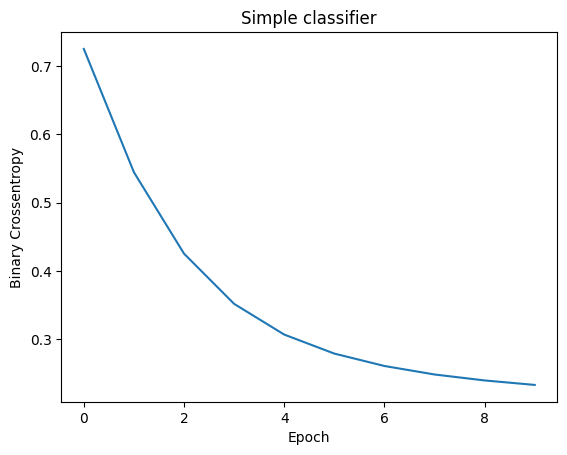

In [5]:
plt.plot(history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy")
plt.title("Simple classifier")
plt.show()

## The distribution of the DNN response

The output of the Neural Network is sometimes called generically the "Response" of the classification. This names is used to stress that the statistical interpretation of this number is more complicated than a probability, even if it is defined between 0 and 1.

For the ideal classifier, with complete knowledge on the generative joint PDFs of the input features, this would indeed be the probability of picking a signal event, from the training dataset, given the input features.
Unfortunately, often the ratio of signal and background entries in the final dataset is not the same as in the training dataset.

In other words, if there is no new physics in the acquired data, the probability of picking a new-physics event is exactly zero independently of what your Neural Network responds.

The distribution of the response is however interesting because it allows to spot immediately pathological behaviours in the learning procedure. Usually you expect a distribution with the background peaking towards 0 and the signal peaking towards 1.

313/313 [==============================] - 0s 975us/step


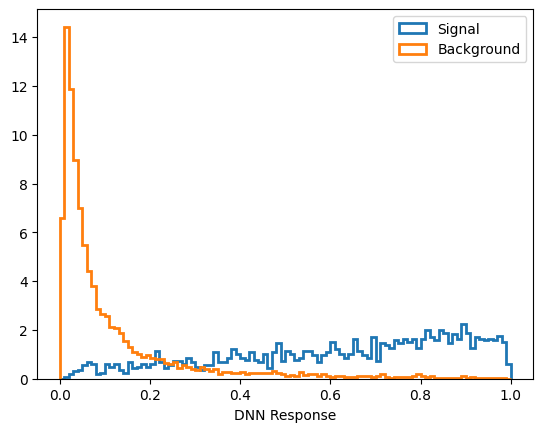

In [6]:
y_hat = classifier.predict(dfh[vars].values)

plt.hist(y_hat[dfh.label==1], bins = np.linspace(0, 1, 101), label="Signal", histtype='step', linewidth=2, density=True)
plt.hist(y_hat[dfh.label==0], bins = np.linspace(0, 1, 101), label="Background", histtype='step', linewidth=2, density=True)
plt.xlabel("DNN Response")
plt.legend()
plt.show()

## Defining a validation sample

Let's extend our example to use a validation sample.
We can randomly pick some thousands of events from our training dataset and assign them to the validation.

Validation datasets should not be used for training, as their purpose is to evaluate the ability of the trained algorithm to generalze to a dataset never used in the training phase.

In [7]:
classifier = tf.keras.models.Sequential()
classifier.add (tf.keras.layers.Dense(128, activation='tanh'))
classifier.add (tf.keras.layers.Dense(1, activation='sigmoid'))

classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-3))

dfh = df.head(10_000)

## Here we randomly select 2048 entries from the dataset
df_validation = dfh.sample(2048)

## And we drop them from the training dataset
df_train = dfh[~dfh.index.isin(df_validation.index)]

history = classifier.fit(
    df_train[vars].values,
    df_train['label'],

    ## Here we define the validation data to monitor the generalization abilities of the NN,
    ## already during the training
    validation_data=(df_validation[vars], df_validation['label']),
    batch_size=1024,
    epochs=10
    )

Epoch 1/10
8/8 [==============================] - 0s 21ms/step - loss: 0.7554 - val_loss: 0.6517
Epoch 2/10
8/8 [==============================] - 0s 5ms/step - loss: 0.5959 - val_loss: 0.5186
Epoch 3/10
8/8 [==============================] - 0s 4ms/step - loss: 0.4834 - val_loss: 0.4270
Epoch 4/10
8/8 [==============================] - 0s 6ms/step - loss: 0.4073 - val_loss: 0.3656
Epoch 5/10
8/8 [==============================] - 0s 9ms/step - loss: 0.3559 - val_loss: 0.3244
Epoch 6/10
8/8 [==============================] - 0s 6ms/step - loss: 0.3219 - val_loss: 0.2955
Epoch 7/10
8/8 [==============================] - 0s 4ms/step - loss: 0.2977 - val_loss: 0.2747
Epoch 8/10
8/8 [==============================] - 0s 4ms/step - loss: 0.2800 - val_loss: 0.2591
Epoch 9/10
8/8 [==============================] - 0s 4ms/step - loss: 0.2668 - val_loss: 0.2470
Epoch 10/10
8/8 [==============================] - 0s 4ms/step - loss: 0.2565 - val_loss: 0.2373


## The evolution of the loss function

Now the evolution of the loss function is more interesting as it make it possible to identify deviations between the loss evaluated on the training and validation samples, raising concerns about possible overtraining.

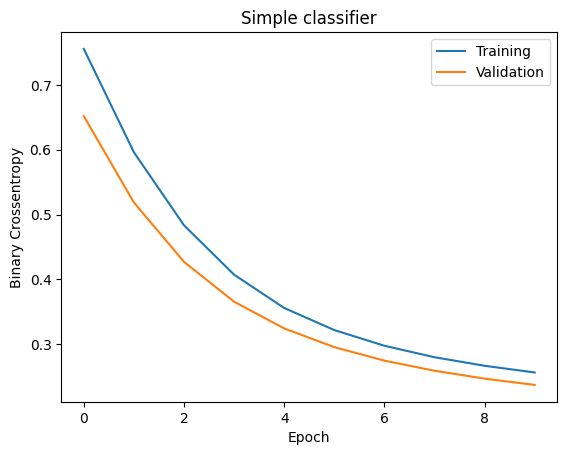

In [8]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy")
plt.title("Simple classifier")
plt.legend()
plt.show()

A further test on the ability of the neural network to generalize is to compare the distribution of the DNN response as obtained from the training and the validation samples.

If the DNN is capable of generalizing, then we expect the two distributions to overlap. Otherwise they will display discrepancies, with the signal and background components in the validation dataset being less "separated" than in the "training" dataset.

64/64 [==============================] - 0s 912us/step


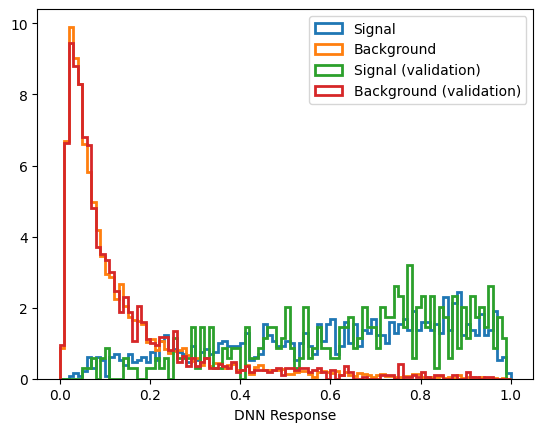

In [9]:
y_train_hat = classifier.predict(df_train[vars].values)
y_validation_hat = classifier.predict(df_validation[vars].values)

plt.hist(y_train_hat[df_train.label==1], bins = np.linspace(0, 1, 101), label="Signal", histtype='step', linewidth=2, density=True)
plt.hist(y_train_hat[df_train.label==0], bins = np.linspace(0, 1, 101), label="Background", histtype='step', linewidth=2, density=True)
plt.hist(y_validation_hat[df_validation.label==1], bins = np.linspace(0, 1, 101), label="Signal (validation)", histtype='step', linewidth=2, density=True)
plt.hist(y_validation_hat[df_validation.label==0], bins = np.linspace(0, 1, 101), label="Background (validation)", histtype='step', linewidth=2, density=True)

plt.xlabel("DNN Response")
plt.legend()
plt.show()

## An example of overtraining

Let's try to make a more complicated neural network with a much smaller dataset to visualize the effect of overtraining.

In [10]:
classifier = tf.keras.models.Sequential()
classifier.add (tf.keras.layers.Dense(128, activation='tanh'))
classifier.add (tf.keras.layers.Dense(128, activation='tanh'))
classifier.add (tf.keras.layers.Dense(1, activation='sigmoid'))

classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(3e-3))

dfh = df.head(500)
df_validation = dfh.sample(100)
df_train = dfh[~dfh.index.isin(df_validation.index)]
print (f"Training entries: {len(df_train)}")
print (f"Validation entries: {len(df_validation)}")

history = classifier.fit(df_train[vars].values, df_train['label'], validation_data=(df_validation[vars], df_validation['label']), batch_size=100, epochs=100)

Training entries: 400
Validation entries: 100
Epoch 1/100
4/4 [==============================] - 0s 31ms/step - loss: 0.4214 - val_loss: 0.4189
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 0.2439 - val_loss: 0.4784
Epoch 3/100
4/4 [==============================] - 0s 7ms/step - loss: 0.2355 - val_loss: 0.4591
Epoch 4/100
4/4 [==============================] - 0s 7ms/step - loss: 0.2038 - val_loss: 0.3907
Epoch 5/100
4/4 [==============================] - 0s 6ms/step - loss: 0.1686 - val_loss: 0.3345
Epoch 6/100
4/4 [==============================] - 0s 7ms/step - loss: 0.1491 - val_loss: 0.2888
Epoch 7/100
4/4 [==============================] - 0s 7ms/step - loss: 0.1489 - val_loss: 0.2705
Epoch 8/100
4/4 [==============================] - 0s 7ms/step - loss: 0.1564 - val_loss: 0.2713
Epoch 9/100
4/4 [==============================] - 0s 7ms/step - loss: 0.1522 - val_loss: 0.2790
Epoch 10/100
4/4 [==============================] - 0s 7ms/step - loss: 0.1466 -

At some point the loss function on the validation sample starts increasing.

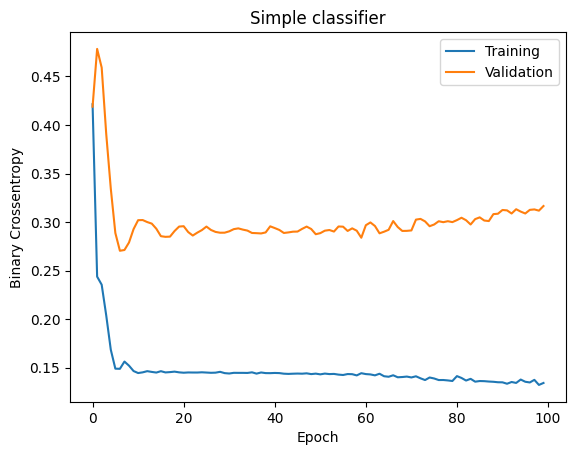

In [11]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy")
plt.title("Simple classifier")
plt.legend()
plt.show()

... as a larger fraction of signal events is discarded as background.


421/421 [==============================] - 0s 957us/step


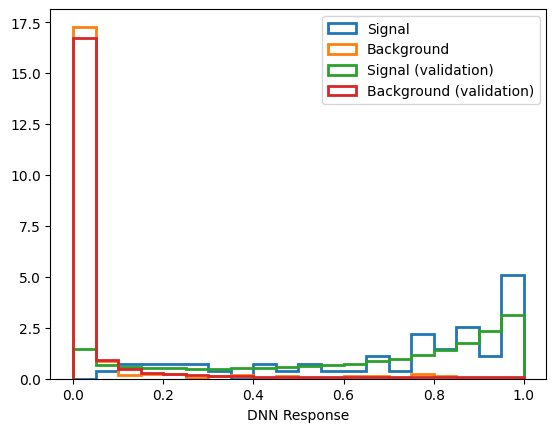

In [12]:
y_train_hat = classifier.predict(df_train[vars].values)
extended_validation = df[~df.index.isin(df_train.index)]
y_validation_hat = classifier.predict(extended_validation[vars].values, batch_size=10_000)

plt.hist(y_train_hat[df_train.label==1], bins = np.linspace(0, 1, 21), label="Signal", histtype='step', linewidth=2, density=True)
plt.hist(y_train_hat[df_train.label==0], bins = np.linspace(0, 1, 21), label="Background", histtype='step', linewidth=2, density=True)
plt.hist(y_validation_hat[extended_validation.label==1], bins = np.linspace(0, 1, 21), label="Signal (validation)", histtype='step', linewidth=2, density=True)
plt.hist(y_validation_hat[extended_validation.label==0], bins = np.linspace(0, 1, 21), label="Background (validation)", histtype='step', linewidth=2, density=True)

plt.xlabel("DNN Response")
plt.legend()
plt.show()

## Receiver-Operator-Characteristic (ROC) Curve and Area Under the Curve (AUC)

To ease the interpretation of the results we wish to apply a cut to the response of the neural network and focus the rest of our analysis on the fraction of events passing that requirement.

Higher statistical power might be obtained by exploiting the whole information instead of simply rejecting candidates that are too unlikely to be signal events, but the increase in statistical power is rarely worth the effort.

Now, if our strategy is to apply a cut to the neural network response, we need to compute the fraction of signal and background events passing the selection, as a function of the threshold.

We name this fraction "efficiency".

The complementary fraction (the fraction of events discarded by the selection) is name "rejection".


Epoch 1/10
8/8 [==============================] - 0s 14ms/step - loss: 0.4804 - val_loss: 0.4367
Epoch 2/10
8/8 [==============================] - 0s 4ms/step - loss: 0.4003 - val_loss: 0.3751
Epoch 3/10
8/8 [==============================] - 0s 4ms/step - loss: 0.3470 - val_loss: 0.3349
Epoch 4/10
8/8 [==============================] - 0s 4ms/step - loss: 0.3118 - val_loss: 0.3086
Epoch 5/10
8/8 [==============================] - 0s 4ms/step - loss: 0.2886 - val_loss: 0.2901
Epoch 6/10
8/8 [==============================] - 0s 4ms/step - loss: 0.2723 - val_loss: 0.2760
Epoch 7/10
8/8 [==============================] - 0s 4ms/step - loss: 0.2596 - val_loss: 0.2646
Epoch 8/10
8/8 [==============================] - 0s 4ms/step - loss: 0.2495 - val_loss: 0.2549
Epoch 9/10
8/8 [==============================] - 0s 4ms/step - loss: 0.2412 - val_loss: 0.2464
Epoch 10/10
64/64 [==============================] - 0s 824us/step


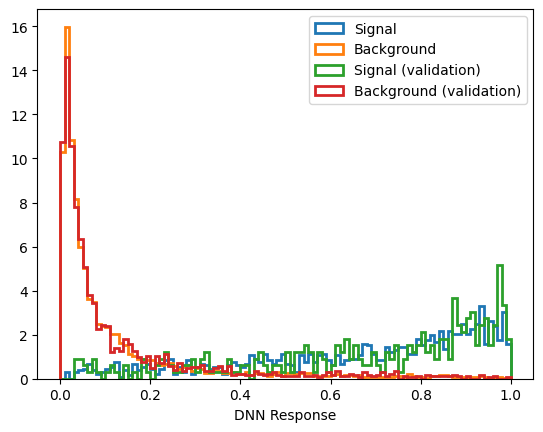

In [13]:
classifier = tf.keras.models.Sequential()
classifier.add (tf.keras.layers.Dense(128, activation='tanh'))
classifier.add (tf.keras.layers.Dense(1, activation='sigmoid'))

classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-3))

dfh = df.head(10_000)
df_validation = dfh.sample(2048)
df_train = dfh[~dfh.index.isin(df_validation.index)]


history = classifier.fit(df_train[vars].values, df_train['label'], validation_data=(df_validation[vars], df_validation['label']), batch_size=1024, epochs=10)

y_train_hat = classifier.predict(df_train[vars].values)
y_validation_hat = classifier.predict(df_validation[vars].values)

plt.hist(y_train_hat[df_train.label==1], bins = np.linspace(0, 1, 101), label="Signal", histtype='step', linewidth=2, density=True)
plt.hist(y_train_hat[df_train.label==0], bins = np.linspace(0, 1, 101), label="Background", histtype='step', linewidth=2, density=True)
plt.hist(y_validation_hat[df_validation.label==1], bins = np.linspace(0, 1, 101), label="Signal (validation)", histtype='step', linewidth=2, density=True)
plt.hist(y_validation_hat[df_validation.label==0], bins = np.linspace(0, 1, 101), label="Background (validation)", histtype='step', linewidth=2, density=True)

plt.xlabel("DNN Response")
plt.legend()
plt.show()

Computing the signal efficiency and background rejection from the distribution of the response is a trivial numpy exercise.

 * Build the histograms
 * Obtain the bin contents from the histograms
 * Compute the cumulative sum of the bin contents (`cumsum`)
 * Normalized the cumulative sum to make it a cumulative distribution


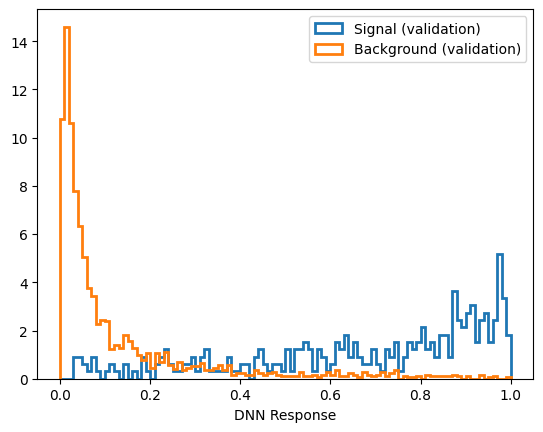

No handles with labels found to put in legend.


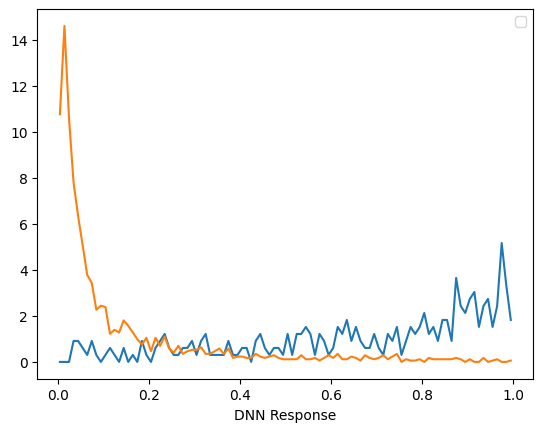

In [14]:
bins = np.linspace(0, 1, 101)
h_sig, _, _ = plt.hist(y_validation_hat[df_validation.label==1], bins=np.linspace(0, 1, 101), label="Signal (validation)", histtype='step', linewidth=2, density=True)
h_bkg, _, _ = plt.hist(y_validation_hat[df_validation.label==0], bins=np.linspace(0, 1, 101), label="Background (validation)", histtype='step', linewidth=2, density=True)

plt.xlabel("DNN Response")
plt.legend()
plt.show()

xAxis = (bins[1:] + bins[:-1])/2
plt.plot(xAxis, h_sig)
plt.plot(xAxis, h_bkg)

plt.xlabel("DNN Response")
plt.legend()
plt.show()

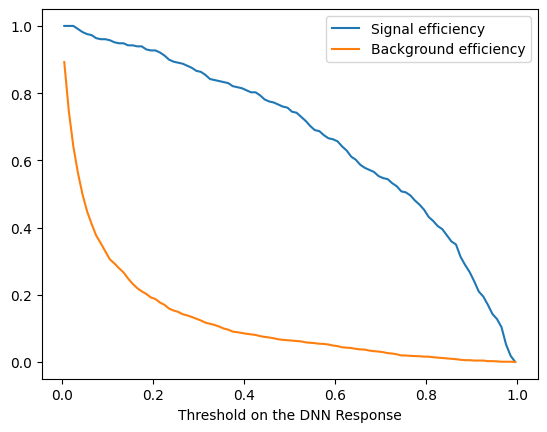

In [15]:
xAxis = (bins[1:] + bins[:-1])/2
plt.plot(xAxis, 1 - np.cumsum(h_sig)/h_sig.sum(), label="Signal efficiency")
plt.plot(xAxis, 1 - np.cumsum(h_bkg)/h_bkg.sum(), label="Background efficiency")

plt.xlabel("Threshold on the DNN Response")
plt.legend()
plt.show()

Signal efficiency and background rejection are usually combined into a unique curve, named Reveiver-Operator-Characteristic (ROC) Curve.

The closer to the point (1, 1), the better!

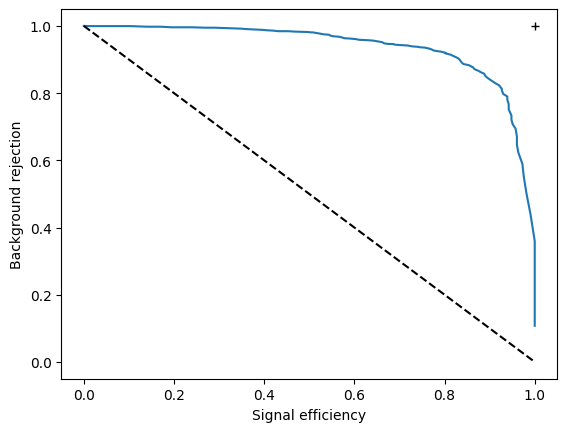

In [16]:
sig_eff = 1 - np.cumsum(h_sig)/h_sig.sum()
bkg_eff = 1 - np.cumsum(h_bkg)/h_bkg.sum()
plt.plot(sig_eff, 1 - bkg_eff)
plt.plot([1], [1], 'k+')
plt.plot([0, 1], [1, 0], 'k--')
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
plt.show()

To define a single-number metric for the ability of our algorithm to distinguish between signal and background, we integrate the ROC curve, defining the *Area Under the Curve* (ROC-AUC). The larger the AUC the better.

In [17]:
## Area Under the (ROC) Curve
auc = abs(np.trapz(x=sig_eff, y=1-bkg_eff))
print (auc)

0.9388622776725694


Keras ease including the the AUC (and other metrics) directly in the training history, by simply defining it at model-compile time.

In [18]:
classifier = tf.keras.models.Sequential()
classifier.add (tf.keras.layers.Dense(128, activation='tanh'))
classifier.add (tf.keras.layers.Dense(1, activation='sigmoid'))

classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['AUC'])

dfh = df.head(10_000)
df_validation = dfh.sample(2048)
df_train = dfh[~dfh.index.isin(df_validation.index)]


history = classifier.fit(df_train[vars].values, df_train['label'], validation_data=(df_validation[vars], df_validation['label']), batch_size=1024, epochs=10)

Epoch 1/10
8/8 [==============================] - 1s 26ms/step - loss: 0.7135 - auc: 0.2282 - val_loss: 0.6254 - val_auc: 0.9393
Epoch 2/10
8/8 [==============================] - 0s 6ms/step - loss: 0.5706 - auc: 0.9331 - val_loss: 0.5064 - val_auc: 0.9379
Epoch 3/10
8/8 [==============================] - 0s 6ms/step - loss: 0.4669 - auc: 0.9359 - val_loss: 0.4223 - val_auc: 0.9368
Epoch 4/10
8/8 [==============================] - 0s 5ms/step - loss: 0.3945 - auc: 0.9365 - val_loss: 0.3650 - val_auc: 0.9365
Epoch 5/10
8/8 [==============================] - 0s 5ms/step - loss: 0.3455 - auc: 0.9359 - val_loss: 0.3261 - val_auc: 0.9365
Epoch 6/10
8/8 [==============================] - 0s 6ms/step - loss: 0.3120 - auc: 0.9362 - val_loss: 0.2997 - val_auc: 0.9368
Epoch 7/10
8/8 [==============================] - 0s 5ms/step - loss: 0.2888 - auc: 0.9370 - val_loss: 0.2813 - val_auc: 0.9374
Epoch 8/10
8/8 [==============================] - 0s 5ms/step - loss: 0.2723 - auc: 0.9378 - val_loss: 

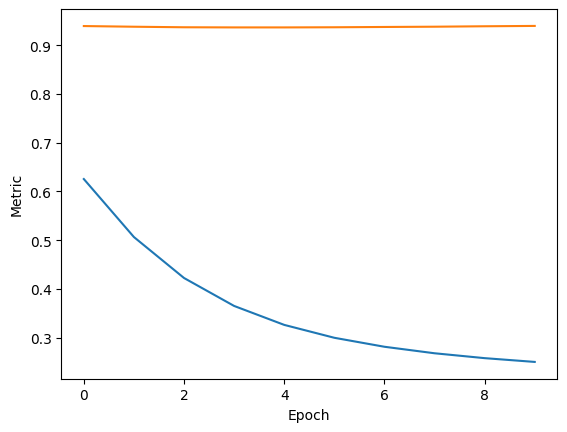

In [19]:
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.plot(history.history['val_auc'], label = "Validation AUC")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.show()

## Model selection

So far, we have just picked one randomly defined neural network and we studied its capability of classifying signal and background and then we designed a metric, the AUC, to evaluate how good is our DNN to the task.

We may wonder if a different choice on the architecture of the neural network would have modified the result. This step is usually named model selection and can be performed in many ways.

A possible (but rather expensive) technique is **Grid Search**. We define a set of possible variations to the model and then we test them all.

For example we can test models with 1, 3, or 5 layers of 128 nodes, each.

In [20]:
def create_dnn(n_layers, n_nodes):
  dnn = tf.keras.models.Sequential()
  for _ in range(n_layers):
    dnn.add (tf.keras.layers.Dense(n_nodes, activation='tanh'))
  dnn.add (tf.keras.layers.Dense(1, activation='sigmoid'))

  dnn.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['AUC'])

  return dnn

dfh = df.head(10_000)
df_validation = dfh.sample(2048)
df_train = dfh[~dfh.index.isin(df_validation.index)]

histories = {}
for n_layers in 1, 3, 5:
  c = create_dnn(n_layers, 128)
  histories[n_layers] = c.fit(df_train[vars].values, df_train['label'], validation_data=(df_validation[vars], df_validation['label']), batch_size=1024, epochs=10)



Epoch 1/10
8/8 [==============================] - 1s 25ms/step - loss: 0.6240 - auc: 0.8595 - val_loss: 0.5452 - val_auc: 0.9422
Epoch 2/10
8/8 [==============================] - 0s 6ms/step - loss: 0.4938 - auc: 0.9373 - val_loss: 0.4426 - val_auc: 0.9415
Epoch 3/10
8/8 [==============================] - 0s 5ms/step - loss: 0.4042 - auc: 0.9398 - val_loss: 0.3756 - val_auc: 0.9403
Epoch 4/10
8/8 [==============================] - 0s 5ms/step - loss: 0.3464 - auc: 0.9393 - val_loss: 0.3326 - val_auc: 0.9398
Epoch 5/10
8/8 [==============================] - 0s 5ms/step - loss: 0.3092 - auc: 0.9391 - val_loss: 0.3046 - val_auc: 0.9396
Epoch 6/10
8/8 [==============================] - 0s 5ms/step - loss: 0.2843 - auc: 0.9398 - val_loss: 0.2858 - val_auc: 0.9398
Epoch 7/10
8/8 [==============================] - 0s 8ms/step - loss: 0.2672 - auc: 0.9403 - val_loss: 0.2726 - val_auc: 0.9404
Epoch 8/10
8/8 [==============================] - 0s 5ms/step - loss: 0.2549 - auc: 0.9409 - val_loss: 

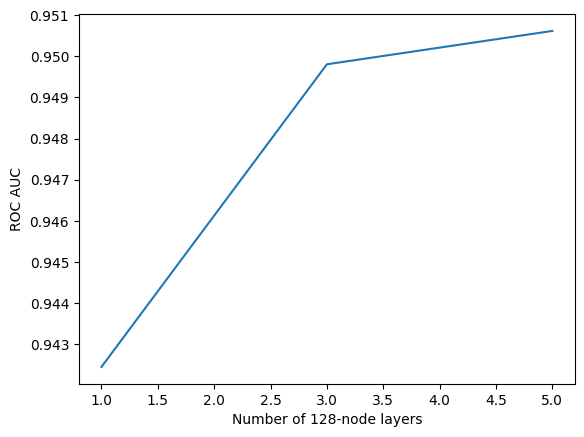

In [21]:
n_layers = list(histories.keys())
plt.plot(n_layers, [histories[nl].history['val_auc'][-1] for nl in n_layers] )
plt.xlabel("Number of 128-node layers")
plt.ylabel("ROC AUC")
plt.show()

If we have more than one parameter to scan, we can nest the loop and test all the possible combinations.

Here, for example, we scan over the number of layers and the number nodes per layer.

The exercise is complicated by the fact that the initialization of the weights defining the behaviour of layers is random. Hence, the performance obtained by two identical neural networks trained from a different initialization might be significantly different.

In general, model selection can be rather expensive.

100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


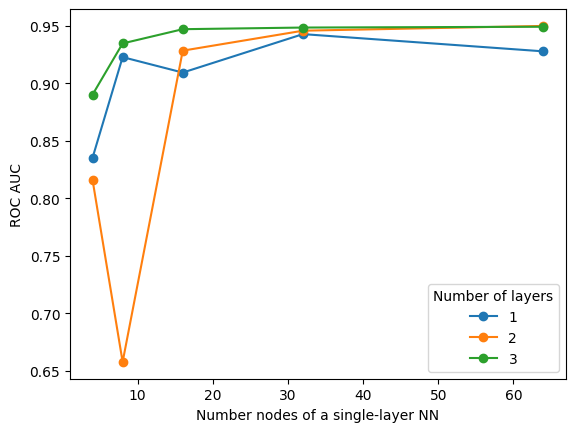

In [22]:
histories = {}
from tqdm import tqdm
for n_layers in 1, 2, 3:
    for n_nodes in tqdm([4, 8, 16, 32, 64]):
        c = create_dnn(n_layers, n_nodes)
        histories[n_nodes] = c.fit(df_train[vars].values, df_train['label'], validation_data=(df_validation[vars], df_validation['label']), batch_size=1024, epochs=10, verbose=False)

        n_nodes = list(histories.keys())
    plt.plot(n_nodes, [histories[nn].history['val_auc'][-1] for nn in n_nodes], 'o-', label=f"{n_layers}" )
plt.xlabel("Number nodes of a single-layer NN")
plt.ylabel("ROC AUC")
plt.legend(title="Number of layers")
plt.show()

## Selection of the working point

Once we have selected the algorithm with the highest possible AUC, we should decide where the put the threshold defining our selection criterion.

The optimal working point depends on the expected number of signal and background events in the final dataset. Such a prediction is usually based on theoretical arguments.

In [23]:
selected_model = create_dnn(2, 32)
history = selected_model.fit(
    df_train[vars].values,
    df_train['label'],
    validation_data=(df_validation[vars], df_validation['label']),
    batch_size=1024,
    epochs=10
    )

Epoch 1/10
8/8 [==============================] - 1s 27ms/step - loss: 0.6754 - auc: 0.5179 - val_loss: 0.5709 - val_auc: 0.9120
Epoch 2/10
8/8 [==============================] - 0s 6ms/step - loss: 0.5085 - auc: 0.9244 - val_loss: 0.4445 - val_auc: 0.9390
Epoch 3/10
8/8 [==============================] - 0s 7ms/step - loss: 0.4020 - auc: 0.9381 - val_loss: 0.3668 - val_auc: 0.9421
Epoch 4/10
8/8 [==============================] - 0s 6ms/step - loss: 0.3368 - auc: 0.9413 - val_loss: 0.3201 - val_auc: 0.9433
Epoch 5/10
8/8 [==============================] - 0s 6ms/step - loss: 0.2977 - auc: 0.9427 - val_loss: 0.2918 - val_auc: 0.9440
Epoch 6/10
8/8 [==============================] - 0s 6ms/step - loss: 0.2736 - auc: 0.9430 - val_loss: 0.2737 - val_auc: 0.9447
Epoch 7/10
8/8 [==============================] - 0s 6ms/step - loss: 0.2578 - auc: 0.9438 - val_loss: 0.2611 - val_auc: 0.9454
Epoch 8/10
8/8 [==============================] - 0s 6ms/step - loss: 0.2464 - auc: 0.9445 - val_loss: 

64/64 [==============================] - 0s 962us/step


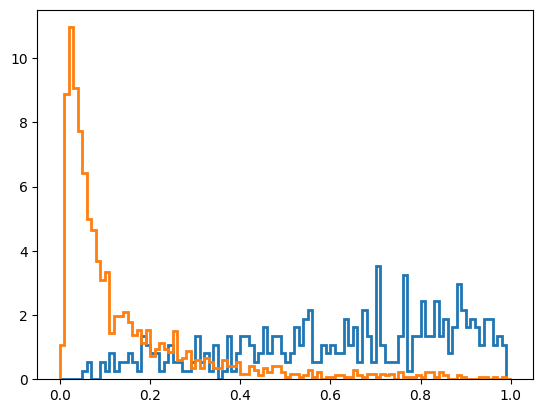

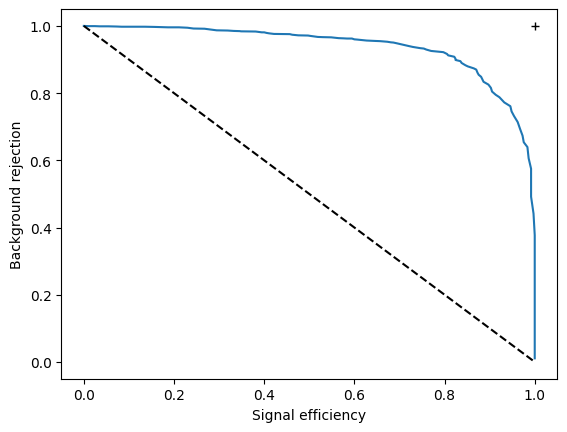

In [24]:
bins = np.linspace(0, 1, 101)
y_validation_hat = classifier.predict(df_validation[vars].values)

h_sig, _, _ = plt.hist(y_validation_hat[df_validation.label==1], bins=np.linspace(0, 1, 101), label="Signal (validation)", histtype='step', linewidth=2, density=True)
h_bkg, _, _ = plt.hist(y_validation_hat[df_validation.label==0], bins=np.linspace(0, 1, 101), label="Background (validation)", histtype='step', linewidth=2, density=True)

plt.show()
sig_eff = 1 - np.cumsum(h_sig)/h_sig.sum()
bkg_eff = 1 - np.cumsum(h_bkg)/h_bkg.sum()
plt.plot(sig_eff, 1 - bkg_eff)
plt.plot([1], [1], 'k+')
plt.plot([0, 1], [1, 0], 'k--')
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
plt.show()

Considering a chosen and trained model, we can try to scan the threshold to study the variation of some metrics describing the "quality" of the selected sample.

There are several metrics that can be considered depending of the kind of analysis we aim at performing on the selected dataset.

A metric that is sometimes useful is the significance
$$
\frac{s(t)}{\sqrt{s(t) + b(t) + 1}}
$$
where $s$ and $b$ represent the number of signal and background events obtained applying the threshold $t$.
We can make the selection efficiency explicit by writing that
$$
s(t) = S\, \varepsilon_S(t)\\
b(t) = B\, \varepsilon_B(t)
$$
where:
 * $S$ and $B$ are the numbers of signal and background events in the dataset, **before** applying any additional selection
 * $\varepsilon_S(t)$ and $\varepsilon_B(t)$ are the selection efficiency of the signal and background candidates as defined above.


Note that such a metric does not only depend on ratio between signal and background events. Below, we compare the dependency of the metric from the chosen threshold for three different scenarios.

The optimal threshold is highlighted with a small circle for each of the three scenarios.


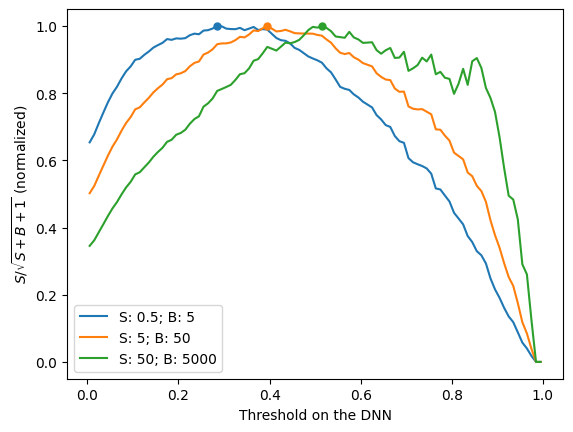

In [25]:
xAxis = (bins[1:] + bins[:-1])/2
for S, B in [(0.5, 5), (5, 50), (50, 5000)]:
    significance = S * sig_eff / np.sqrt(S * sig_eff + B * bkg_eff + 1)
    line, = plt.plot(xAxis, significance/significance.max(), label=f"S: {S}; B: {B}")
    plt.plot([xAxis[np.argmax(significance)]], [1], 'o',  markersize=5, color=line.get_color())

plt.xlabel("Threshold on the DNN")
plt.ylabel("$S / \sqrt{S + B + 1}$ (normalized)")
plt.legend()
plt.show()

## A simple toy study

Let's see all that in action.

Let's pick one of the scenario assumed above, for example let's say that with our preliminary selection strategy we expect to have a dataset in which 5000 events are purely due to Standard Model physics, while 50 are due to new physics effects. Then we "create" such a dataset.

1. We randomize the number of signal and background events throwing a random number from a Poissonian distribution
2. We apply our trained model to the crafted dataset
3. We take the pure Standard Model dataset (background) and we estimate the expectaions under such a "null hypothesis" and then we compare what we "observe" in the crafted dataset with the expectaions.

350/350 [==============================] - 0s 1ms/step


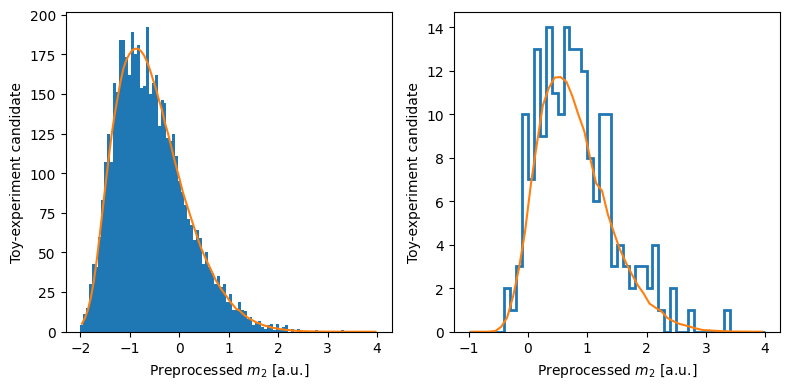

In [26]:
bkg = bkg.copy()

expected_signal = 50
expected_background = 5000

toy_sig = sig.sample(np.random.poisson(expected_signal))
toy_bkg = bkg.sample(np.random.poisson(expected_background))

toy = pd.concat((toy_sig, toy_bkg), axis=0)

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
bins = np.linspace(-2, 4, 101)
xAxis = (bins[1:] + bins[:-1])/2
plt.hist(toy['m2'], bins=bins)
bkg_model, _ = np.histogram(bkg['m2'], bins=bins)
plt.plot(xAxis, bkg_model * expected_background / len(bkg))

plt.xlabel("Preprocessed $m_2$ [a.u.]")
plt.ylabel("Toy-experiment candidate")

plt.subplot(1, 2, 2)
toy['y_hat'] = selected_model.predict(toy[vars].values)
bkg['y_hat'] = selected_model.predict(bkg[vars].values, batch_size=10000)
bins = np.linspace(-1, 4, 51)
xAxis = (bins[1:] + bins[:-1])/2

plt.hist(toy.query('y_hat > 0.7')['m2'], bins=bins, histtype='step', linewidth=2)
bkg_model, _ = np.histogram(bkg.query('y_hat > 0.7')['m2'], bins=bins)
plt.plot(xAxis, bkg_model * expected_background / len(bkg))
plt.xlabel("Preprocessed $m_2$ [a.u.]")
plt.ylabel("Toy-experiment candidate")

plt.tight_layout()
plt.show()



The distributions are not very different for signal and background, event after applying the multivariate selection. So we may start with a simple counting experiment, comparing the number of observed and expected events.

To make the exercise statistically relevant, we repeat it 100 times assuming 50 signal events (before the selection) and 100 times assuming the pure Standard Model dataset and we compare the excess of events in the two cases.


71/71 [==============================] - 0s 885us/step


100%|██████████| 100/100 [00:10<00:00,  9.27it/s]


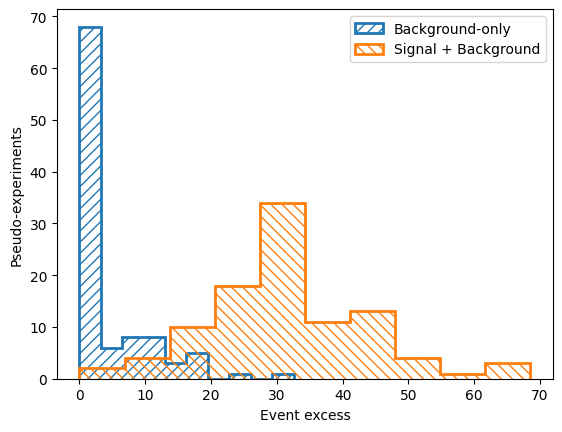

In [27]:
sig, bkg = sig.copy(), bkg.copy()

bkg['y_hat'] = selected_model.predict(bkg[vars].values, batch_size=10000)
sig['y_hat'] = selected_model.predict(sig[vars].values, batch_size=10000)

def one_toy(expected_signal, expected_background):
    toy_sig = sig.sample(np.random.poisson(expected_signal))
    toy_bkg = bkg.sample(np.random.poisson(expected_background))

    toy = pd.concat((toy_sig, toy_bkg), axis=0)

    bins = np.linspace(-1, 4, 51)
    xAxis = (bins[1:] + bins[:-1])/2

    bkg_model, _ = np.histogram(bkg.query('y_hat > 0.7')['m2'], bins=bins)

    return max(0, len(toy.query('y_hat > 0.7')) - (bkg_model.sum() * expected_background / len(bkg)))

from tqdm import trange
plt.hist([one_toy(0, 5000) for _ in trange(100)], label="Background-only", histtype='step', linewidth=2, hatch='///')
plt.hist([one_toy(50, 5000) for _ in trange(100)], label="Signal + Background", histtype='step', linewidth=2, hatch='\\\\\\')
plt.xlabel("Event excess")
plt.ylabel("Pseudo-experiments")
plt.legend()
plt.show()

# Conclusion
In this notebook we went through a first classical application of multivariate methods in High Energy Physics, focussing on the application of a neural network to the enhancement of the signal contribution in a dataset.

We discussed model selection and defined the threshold for the selection criterion based on the maximisation of a metric.
Finally we built a pseudo-experiment to assess our ability of making a discovery based on the trained model.

Each of the steps introduced in this overview would require (at least) one dedicated day of discussion to be covered in some depth. In this introductory lecture we tried to give a conceptual overview of why they are needed and how they are pipelined. More will be discussed during the exercises of the hackathon.

## Proposed exercises

1. Try to break things making some changes to some parameter (number of layers, learning rates, optimizer, number of expected signal and background...) and see the effect on the final result. Try to understand what is happening and why.

2. Try to assess the sensitivity of your experiment in case the mass of the actual new-physics state were different from the one used for training.

3. Try to train different models for different mass hypotheses. Can you "interpolate" models for intermediate mass values?
